In [9]:
# Define an environment at OpenAI style

In [10]:
import random as rnd
import numpy as np

In [11]:
class Passenger:
    def __init__(self, pid):
        self.id=pid
        self.isWindower=str(self.id).endswith('w')
        self.position=None
        self.status=0 # 0:'QUEUED_TO_BOARD', 1:'NEXT_TO_BOARD', 2:'PLACED_IN_PLANE'

In [12]:
class PassengerList:
    def __init__(self, groups):
        self.groups=groups.copy()
        self.index_group=0
        self.index_passenger_ingroup=0
        self.completed=False
        self.groups[0][0].status=1
    
    def getTotalPassengerNumber(self):
        n = 0
        for g in self.groups:
            for p in g:
                n = n + 1
        return n
    
    def getNextAndUpdate(self):
        current_passenger = self.getNext()
        if current_passenger is None:
            return None
        else:
            self.index_passenger_ingroup = (self.index_passenger_ingroup + 1) % len(self.groups[self.index_group])
            if (self.index_passenger_ingroup == 0):
                self.index_group = (self.index_group + 1) % len(self.groups)
                if (self.index_group == 0):
                    self.completed = True
            if (self.completed==False):
                self.groups[self.index_group][self.index_passenger_ingroup].status=1
            return current_passenger
    
    def getNext(self):
        if (self.completed):
            return None
        else:
            return self.groups[self.index_group][self.index_passenger_ingroup]

    def canRotate(self):
        g = self.groups[self.index_group]
        if (g[self.index_passenger_ingroup].isWindower):
            return False
        else:
            size = len(g)
            for i in range(self.index_passenger_ingroup+1,size):
                if (g[i].isWindower):
                    return True
        return False
    
    def rotate(self):
        if (self.canRotate()):
            g = self.groups[self.index_group]
            size = len(g)
            p = g[self.index_passenger_ingroup]
            for i in range(self.index_passenger_ingroup+1,size):
                g[i-1]=g[i]
            g[size-1]=p
            return True
        else:
            return False


In [13]:
class Plane:
    def __init__(self, plane_dims):
        self.plane_dims=plane_dims
        self.plane=[]
        for i in range(plane_dims[0]):
            row = [None for j in range(plane_dims[1])]
            self.plane.append(row)
    
    def roomInRow(self,row_num):
        if (self.plane[row_num][-1]==None):
            return True
        else:
            return False
    
    def setPassengerInRow(self, passenger, row_num):
        for i in range(self.plane_dims[1]):
            if (self.plane[row_num][i] is None):
                self.plane[row_num][i] = passenger
                passenger.position=(row_num,i)
                passenger.status=2
                return
            
    def getPosition(self, passenger):
        for i in range(self.plane_dims[0]):
            for j in range(self.plane_dims[1]):
                if (self.plane[i][j] is not None):
                    if (self.plane[i][j].id == passenger.id):
                        return (i,j)
        return (0, 0)
    
    def drawPlane(self):
        for i in range(self.plane_dims[0]):
            row=[(str(x.id) + " ") for x in self.plane[i]]
            print(row)

In [14]:
class PlaneEnv:
    def __init__(self, file_name):
        self.file_name=file_name
        self.reset()

    def reset(self):
        file = open(self.file_name, 'r')
        
        # read plane dimensions
        plane_dims=[int(x) for x in file.readline().replace('\n','').split(' ')]
        
        # read Groups
        self.Groups = []
        more_groups = True
        while more_groups:
            line = file.readline()
            if line is not '':
                passengers = [Passenger(x) for x in line.replace('\n','').split(' ')]
                self.Groups.append(passengers)
            else:
                more_groups = False
        self.passengerList = PassengerList(self.Groups)
        
        # End reading
        file.close()

        # Creating Empty Plane
        self.plane = Plane(plane_dims)
        
        # set actions
        self.actions=[]
        for i in range(plane_dims[0]):
            self.actions.append(i) # insert passanger at i row
        self.actions.append(plane_dims[0]) # state for rotating passanger in group
        
        return np.zeros(11*self.passengerList.getTotalPassengerNumber())
            
    # retrieve number of actions
    def action_space_n(self):
        return len(self.actions)
    
    # retrieve a random action.
    def action_space_sample(self):
        valid_action = False
        action = None
        while valid_action==False:
            action = self.actions[rnd.randint(0,self.action_space_n()-1)]
            if (action < self.action_space_n()-1):
                if (self.plane.roomInRow(action)):
                    valid_action = True
            elif (action == self.action_space_n()-1 & self.passengerList.canRotate() ):
                valid_action = True
        return action
    
    # Run a step. Return: observation (std normalized), reward, done
    def step(self, action):
        # Action execution
        if (action == self.action_space_n()):
            if (self.passengerList.canRotate()):
                self.passengerList.rotate()
            else:
                print("WARN: rotate group " + self.index_group + " is not possible!")
        else:
            if ( self.plane.roomInRow(action) ):
                passenger = self.passengerList.getNextAndUpdate()
                if (passenger is not None):
                    self.plane.setPassengerInRow(passenger, action)
                else:
                    print("WARN: there is no more passenger for boarding")
            #else:
            #    print("WARN: there is not room in row " + str(action))

        # Check if episode is finished
        done = self.passengerList.completed

        # Reward evaluation. Only after the end
        reward = 0
        if (done):
            for group in self.Groups:
                reward = reward + self.__groupedLevel__(group)
            reward = reward + self.__windowLevel__()
        
        return (self.__s2x__(), reward, done)
    
    # Transform state in gaussian normalized vector X
    # each passanger in original order: p0 p1 S0 S1 S2 W G0 G1 G2 G3 .. Gn
    def __s2x__(self):
        p_x = []
        nGroups = len(self.Groups)
        g_index = 0
        for group in self.Groups:
            for p in group:
                # Position
                (posX, posY)=self.plane.getPosition(p)
                p_x.append(posX)
                p_x.append(posY)
                
                # state
                stsoh = self.__one_hot__(p.status,3)
                p_x = self.__append__(p_x, stsoh)
                
                # window
                if (p.isWindower == True):
                    p_x.append(1)
                else:
                    p_x.append(0)
                
                # group
                goh = self.__one_hot__(g_index,nGroups)
                p_x = self.__append__(p_x, goh)
            g_index = g_index + 1
        return np.array(p_x)
    
    def __one_hot__(self, value, labels):
        targets = np.array([value])
        ohm = np.zeros((targets.shape[0], labels))
        #empty one-hot matrix
        ohm[np.arange(targets.shape[0]), targets] = 1
        return ohm[0].tolist()
    
    def __append__(self, init, add):
        for c in add:
            init.append(c)
        return init

    # Group Percentage of grouping
    def __groupedLevel__(self, group):
        id_group = [x.id for x in group]
        #print('-> id_group: ' + str(id_group))
        g_partial = []
        g_total = len(id_group)
        for i in range(self.plane.plane_dims[0]):
            g_row = 0
            for j in range(self.plane.plane_dims[1]):
                if (self.plane.plane[i][j].isWindower is not None):
                    if (self.plane.plane[i][j].id in id_group):
                        #print('---> id: ' + str(i) + ', ' + str(self.plane.plane[i][j].id))
                        g_row = g_row + 1
            g_partial.append(g_row)
        return float(max(g_partial)/g_total)*100
    
    # Percentage of passangers in window
    def __windowLevel__(self):
        w_ok = 0
        w_total = 0
        for i in range(self.plane.plane_dims[0]):
            for j in range(self.plane.plane_dims[1]):
                if (self.plane.plane[i][j].isWindower is not None):
                    if (self.plane.plane[i][j].isWindower):
                        w_total = w_total + 1
                        if (j == 0):
                            w_ok = w_ok + 1
        return float(w_ok/w_total)*100

## Testing functions

In [15]:
env = PlaneEnv('plane1.txt')

In [16]:
env.action_space_sample()

2

In [17]:
for g in env.Groups:
    for p in g:
        print(p.id + " - " + str(p.status))

1w - 1
2 - 0
3 - 0
4 - 0
5 - 0
6 - 0
7 - 0
8 - 0
9w - 0
10 - 0
11 - 0
12 - 0
13 - 0
14 - 0
15 - 0
16 - 0


In [18]:
passengers = env.passengerList

In [19]:
passengers.getNext().id

'1w'

In [20]:
passengers.canRotate()

False

In [21]:
passengers.rotate()

False

In [22]:
#passengers.getNextAndUpdate().id

In [23]:
while (passengers.completed==False):
    id=passengers.getNextAndUpdate().id
    print("id: " + str(id))

id: 1w
id: 2
id: 3
id: 4
id: 5
id: 6
id: 7
id: 8
id: 9w
id: 10
id: 11
id: 12
id: 13
id: 14
id: 15
id: 16


## Testing Environment 

In [24]:
env = PlaneEnv('plane1.txt')

In [25]:
iters = 200
rewards = []
for i in range(iters):
    env.reset()
    done = False
    while (done == False):
        action = env.action_space_sample()
        (x, reward, done) = env.step(action)
        #if (i%15):
        #    print(x)
        
    #env.plane.drawPlane()
    rewards.append(reward)
    #print("iter: " + str(i) + ", reward: " + str(reward))
    #print()


In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

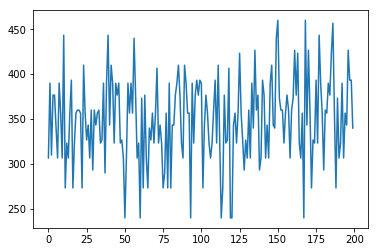

In [27]:
plt.plot(rewards)

# Q-Learning 

In [28]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDRegressor

In [29]:
class FeatureTransformer:
    def __init__(self, env, n_components=500):
        observation_examples = self.__getObservations__(env, 1000)
        scaler = StandardScaler()
        scaler.fit(observation_examples)

        # Used to converte a state to a featurizes represenation.
        # We use RBF kernels with different variances to cover different parts of the space
        featurizer = FeatureUnion([
                ("rbf1", RBFSampler(gamma=5.0, n_components=n_components)),
                ("rbf2", RBFSampler(gamma=2.0, n_components=n_components)),
                ("rbf3", RBFSampler(gamma=1.0, n_components=n_components)),
                ("rbf4", RBFSampler(gamma=0.5, n_components=n_components))
                ])
        example_features = featurizer.fit_transform(scaler.transform(observation_examples))

        self.dimensions = example_features.shape[1]
        self.scaler = scaler
        self.featurizer = featurizer

    def transform(self, observations):
        # print "observations:", observations
        scaled = self.scaler.transform(observations)
        # assert(len(scaled.shape) == 2)
        return self.featurizer.transform(scaled)
    
    def __getObservations__(self, env, iters):
        data=[]
        for i in range(iters):
            env.reset()
            done = False
            while (done == False):
                action = env.action_space_sample()
                (x, reward, done) = env.step(action)
                data.append(x)
        return np.array(data)

In [30]:
# Holds one SGDRegressor for each action
class Model:
    def __init__(self, env, feature_transformer, learning_rate):
        self.env = env
        self.models = []
        self.feature_transformer = feature_transformer
        for i in range(env.action_space_n()):
            model = SGDRegressor(learning_rate=learning_rate, max_iter=1000, tol=1e-3)
            model.partial_fit(feature_transformer.transform( [env.reset()] ), [0])
            self.models.append(model)

    def predict(self, s):
        X = self.feature_transformer.transform([s])
        result = np.stack([m.predict(X) for m in self.models]).T
        assert(len(result.shape) == 2)
        return result

    def update(self, s, a, G):
        X = self.feature_transformer.transform([s])
        assert(len(X.shape) == 2)
        self.models[a].partial_fit(X, [G])

    def sample_action(self, s, eps):
        # eps = 0
        # Technically, we don't need to do epsilon-greedy
        # because SGDRegressor predicts 0 for all states
        # until they are updated. This works as the
        # "Optimistic Initial Values" method, since all
        # the rewards for Mountain Car are -1.
        if np.random.random() < eps:
              return self.env.action_space_sample()
        else:
              return np.argmax(self.predict(s))

In [31]:
# returns a list of states_and_rewards, and the total reward
def play_one(model, env, eps, gamma):
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0
    while not done and iters < 10000:
        action = model.sample_action(observation, eps)
        prev_observation = observation
        (observation, reward, done) = env.step(action)

        # update the model
        next = model.predict(observation)
        # assert(next.shape == (1, env.action_space.n))
        G = reward + gamma*np.max(next[0])
        model.update(prev_observation, action, G)

        totalreward += reward
        iters += 1

    if (done == False):
        print("WARN: More iterations required")
        
    return totalreward

In [32]:
def plot_running_avg(totalrewards):
    N = len(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()
    plt.plot(running_avg)
    plt.title("Running Average")
    #plt.show()

In [33]:
def main(show_plots=True):
    env = PlaneEnv('plane1.txt')
    ft = FeatureTransformer(env)
    model = Model(env, ft, "constant")
    gamma = 0.99

    N = 100
    totalrewards = np.empty(N)
    for n in range(N):
        # eps = 1.0/(0.1*n+1)
        eps = 0.1*(0.97**n)
        if n == 199:
            print("eps:", eps)
        # eps = 1.0/np.sqrt(n+1)
        totalreward = play_one(model, env, eps, gamma)
        totalrewards[n] = totalreward
        if (n + 1) % 100 == 0:
            print("episode:", n, "total reward:", totalreward)
        print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
        print("total steps:", -totalrewards.sum())

    if show_plots:
        plt.plot(totalrewards)
        plt.title("Rewards")
        #plt.show()

    env.plane.drawPlane()
    plot_running_avg(totalrewards)

avg reward for last 100 episodes: 4.6
total steps: -460.0
avg reward for last 100 episodes: 8.36666666667
total steps: -836.666666667
avg reward for last 100 episodes: 11.4333333333
total steps: -1143.33333333
avg reward for last 100 episodes: 16.0333333333
total steps: -1603.33333333
avg reward for last 100 episodes: 20.1333333333
total steps: -2013.33333333
avg reward for last 100 episodes: 24.2333333333
total steps: -2423.33333333
avg reward for last 100 episodes: 29.0333333333
total steps: -2903.33333333
avg reward for last 100 episodes: 32.1
total steps: -3210.0
avg reward for last 100 episodes: 35.8333333333
total steps: -3583.33333333
avg reward for last 100 episodes: 39.7333333333
total steps: -3973.33333333
avg reward for last 100 episodes: 42.4666666667
total steps: -4246.66666667
avg reward for last 100 episodes: 47.0666666667
total steps: -4706.66666667
avg reward for last 100 episodes: 50.9666666667
total steps: -5096.66666667
avg reward for last 100 episodes: 55.6
total s

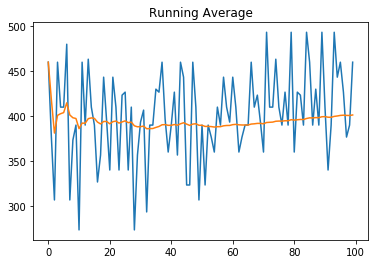

In [34]:
main()